This notebook tries to extend the results from the adversarial spheres paper: https://arxiv.org/pdf/1801.02774.pdf

In particular, instead of generating from spheres, we generate from Gaussians
(with the hope that the high dimensionality makes them effectively spheres).

This is an iteration on top of gaussian-v1.ipynb.
Unlike the first notebook,
we focus on the norm $O(1)$ regime in this notebook,
since this is where the vanilla NN performs the best.
The plan is to also study the NTK of this vanilla NN in the future.

Greg Yang's framework can also compute NTK even with batchnorm?

We also provide visualizations of what the network is doing at different radii.

### Import dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from art.data_generators import TensorFlowV2DataGenerator
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import ProjectedGradientDescent
from art.defences.trainer import AdversarialTrainer

tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Data generation utils

In [2]:
def generate_normal_data(dim, s0, s1, num_samples):
    assert num_samples % 2 == 0
    assert s0 <= s1
    
    ys = np.concatenate([
        np.zeros(shape=num_samples // 2, dtype=np.int64),
        np.ones(shape=num_samples // 2, dtype=np.int64)
    ])
    
    xs = np.concatenate([
        np.random.normal(scale=s0, size=(num_samples // 2, dim)),
        np.random.normal(scale=s1, size=(num_samples // 2, dim))
    ])
    
    perm = np.random.permutation(num_samples)
    xs = xs[perm]
    ys = ys[perm]
    
    return xs, ys

def normalize(xs: np.ndarray, norm):
    norm_xs = xs / np.linalg.norm(xs, axis=-1, ord=norm).reshape(-1, 1)
    return norm_xs

def radial_attack(
    xs: np.ndarray, ys: np.ndarray,
    attack_norm, attack_eps,
):
    norm_xs = normalize(xs, norm=attack_norm)
    
    adv_xs = xs.copy()
    adv_xs[ys == 0] += attack_eps * norm_xs[ys == 0]
    adv_xs[ys == 1] -= attack_eps * norm_xs[ys == 1]
    
    return adv_xs

xs, ys = generate_normal_data(dim=2, s0=0.3, s1=0.7, num_samples=4)
radial_attack(xs=xs, ys=ys, attack_norm=2, attack_eps=0.1)

array([[-0.10052   ,  0.40770094],
       [-0.60192096,  0.44885005],
       [-0.42508932,  0.03052352],
       [-0.00636089, -0.38963944]])

### Experiment setup

In [3]:
def eval_model(
    model: tf.keras.Model,
    xs: np.ndarray,
    ys: np.ndarray,
    verbose=0,
):
    """Returns accuracies per class"""
    _, acc0 = model.evaluate(xs[ys == 0], ys[ys == 0], verbose=verbose)
    _, acc1 = model.evaluate(xs[ys == 1], ys[ys == 1], verbose=verbose)
    return acc0, acc1

def fmt_accs(accs):
    return "(" + ", ".join(f"{a:.4f}" for a in accs) + ")"

fmt_accs([1,2])

'(1.0000, 2.0000)'

In [4]:
def run_experiment_v2(
    dim, s0, s1,
    num_train,
    model_layers,
    train_epochs,
    attack_norm,
    attack_eps,
    attack_eps_step,
    attack_iters,
    train_batch_size=64,
    attack_batch_size=256,
    num_test=4096,
    seed=42,
    adv_train=False,
    adv_train_log_interval=2, # measured in epochs
):
    """
    Default values for num_train and num_test are size of CIFAR10 dataset.
    
    Keras code derived from https://keras.io/examples/vision/mnist_convnet/.
    
    ART code derived from https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/adversarial_retraining.ipynb
    and https://github.com/Trusted-AI/adversarial-robustness-toolbox/issues/238.
    """
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    x_train, y_train = generate_normal_data(
        dim=dim, s0=s0, s1=s1,
        num_samples=num_train,
    )

    x_test, y_test = generate_normal_data(
        dim=dim, s0=s0, s1=s1,
        num_samples=num_test,
    )
    
    model = keras.Sequential(
        [keras.Input(shape=x_train[0].shape)]
        + model_layers
    )
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer="adam",
        metrics=["accuracy"]
    )
    
    # Wrapper around tf.keras.Model.train_step
    # Used for compatibility with art.estimators.classification.TensorFlowV2Classifier
    _sample_count = 0
    art_pgd_attack = None # Forward declaration. Hacky...
    def train_step(model, images, labels):
        nonlocal _sample_count
        nonlocal art_pgd_attack
        
        out = model.train_step((images, labels))
        
        old_sample_count = _sample_count
        _sample_count += images.shape[0]
        
        old_epoch = old_sample_count // num_train
        cur_epoch = _sample_count // num_train
        
        if old_epoch < cur_epoch:
            if old_epoch % adv_train_log_interval == 0:
                x_val = art_pgd_attack.generate(x_test, y=y_test)
                val_accs = eval_model(model, x_val, y_test)
                
                loss = float(out["loss"])
                acc = float(out["accuracy"])
                print(f"Finished epoch {old_epoch}; acc={acc:.4f}; val_accs={fmt_accs(val_accs)}; loss={loss}")
                
            model.reset_metrics()
    
    art_model = TensorFlowV2Classifier(
        model=model,
        input_shape=x_test[0].shape,
        nb_classes=2,
        clip_values=None, #[-x_test.max(), x_test.max()],
        loss_object=model.loss,
        train_step=train_step,
    )
    art_pgd_attack = ProjectedGradientDescent(
        art_model,
        norm=attack_norm,
        eps=attack_eps,
        eps_step=attack_eps_step,
        max_iter=attack_iters,
        batch_size=attack_batch_size,
    )
    
    try: # Catch keyboard interrupt so we can exit training early
        if adv_train:
            adv_trainer = AdversarialTrainer(art_model, attacks=art_pgd_attack, ratio=1.0)
            adv_trainer.fit(x=x_train, y=y_train, batch_size=train_batch_size, nb_epochs=train_epochs)
        else:
            model.fit(
                x_train,
                y_train,
                batch_size=train_batch_size,
                epochs=train_epochs,
                validation_data=(x_test, y_test),
                verbose=2,
            )
    except KeyboardInterrupt:
        pass

    model.trainable = False
    
    x_train_adv_pgd = art_pgd_attack.generate(x_train[:num_test], y=y_train[:num_test])    
    x_test_adv_pgd = art_pgd_attack.generate(x_test, y=y_test)
    
    x_train_adv_rad = radial_attack(xs=x_train[:num_test], ys=y_train[:num_test],
                                    attack_norm=attack_norm, attack_eps=attack_eps)
    x_test_adv_rad = radial_attack(xs=x_test, ys=y_test,
                                   attack_norm=attack_norm, attack_eps=attack_eps)
    
    nat_train_accs = eval_model(model, x_train, y_train)
    nat_test_accs = eval_model(model, x_test, y_test)
    adv_pgd_train_accs = eval_model(model, x_train_adv_pgd, y_train[:num_test])
    adv_pgd_test_accs = eval_model(model, x_test_adv_pgd, y_test)
    adv_rad_train_accs = eval_model(model, x_train_adv_rad, y_train[:num_test])
    adv_rad_test_accs = eval_model(model, x_test_adv_rad, y_test)
    
    print("Nat train accs     :", fmt_accs(nat_train_accs))
    print("Nat test  accs     :", fmt_accs(nat_test_accs))
    print("Adv-pgd train accs :", fmt_accs(adv_pgd_train_accs))
    print("Adv-pgd test  accs :", fmt_accs(adv_pgd_test_accs))
    print("Adv-rad train accs :", fmt_accs(adv_rad_train_accs))
    print("Adv-rad test  accs :", fmt_accs(adv_rad_test_accs))
    
    return dict(
        model=model,
        train_data=(x_train, y_train),
        test_data=(x_test, y_test),
        x_train_adv_pgd=x_train_adv_pgd,
        x_test_adv_pgd=x_test_adv_pgd,
        x_train_adv_rad=x_train_adv_rad,
        x_test_adv_rad=x_test_adv_rad,
    )

In [5]:
def cls1_frac_by_rad(
    model: tf.keras.Model,
    rads: np.ndarray,
    num_samples_per_rad=256,
    batch_size=64,
):
    dim = model.input_shape[-1]
    
    cls1_fracs = np.zeros_like(rads)
    for idx, r in enumerate(tqdm(rads, leave=False)):
        xs = r * normalize(
            xs=np.random.normal(size=(num_samples_per_rad, dim)),
            norm=2
        )

        pred_probs = model.predict(xs, batch_size=batch_size)
        preds = np.argmax(pred_probs, axis=-1)
        
        cls1_fracs[idx] = (preds == 1).mean()
        
    return cls1_fracs

### Run experiments

Norm $O(1)$, standard training

In [6]:
%%time
D = 1000
res = run_experiment_v2(
    dim=D, s0=1.0 / np.sqrt(D), s1=1.3 / np.sqrt(D),
    num_train=10 ** 4,
    model_layers=[
        layers.Dense(1000, activation="relu"),
        layers.Dense(1000, activation="relu"),
        layers.Dense(2),
    ],
    train_batch_size=128,
    train_epochs=10,
    attack_norm=2,
    attack_eps=0.1,
    attack_eps_step=0.01,
    attack_iters=20,
)

Epoch 1/10
79/79 - 2s - loss: 0.4557 - accuracy: 0.7743 - val_loss: 0.1620 - val_accuracy: 0.9568
Epoch 2/10
79/79 - 0s - loss: 0.0225 - accuracy: 0.9957 - val_loss: 0.1231 - val_accuracy: 0.9509
Epoch 3/10
79/79 - 0s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0664 - val_accuracy: 0.9792
Epoch 4/10
79/79 - 0s - loss: 5.2766e-04 - accuracy: 1.0000 - val_loss: 0.0654 - val_accuracy: 0.9780
Epoch 5/10
79/79 - 0s - loss: 2.9580e-04 - accuracy: 1.0000 - val_loss: 0.0691 - val_accuracy: 0.9756
Epoch 6/10
79/79 - 0s - loss: 2.0632e-04 - accuracy: 1.0000 - val_loss: 0.0658 - val_accuracy: 0.9763
Epoch 7/10
79/79 - 0s - loss: 1.5428e-04 - accuracy: 1.0000 - val_loss: 0.0667 - val_accuracy: 0.9756
Epoch 8/10
79/79 - 0s - loss: 1.2044e-04 - accuracy: 1.0000 - val_loss: 0.0669 - val_accuracy: 0.9756
Epoch 9/10
79/79 - 0s - loss: 9.6693e-05 - accuracy: 1.0000 - val_loss: 0.0659 - val_accuracy: 0.9758
Epoch 10/10
79/79 - 0s - loss: 7.9382e-05 - accuracy: 1.0000 - val_loss: 0.0667 - val_accuracy

PGD - Batches: 0it [00:00, ?it/s]

PGD - Batches: 0it [00:00, ?it/s]

Nat train accs     : (1.0000, 1.0000)
Nat test  accs     : (0.9985, 0.9526)
Adv-pgd train accs : (0.7148, 0.5854)
Adv-pgd test  accs : (0.1289, 0.0771)
Adv-rad train accs : (1.0000, 1.0000)
Adv-rad test  accs : (0.8716, 0.6401)
Wall time: 9.08 s


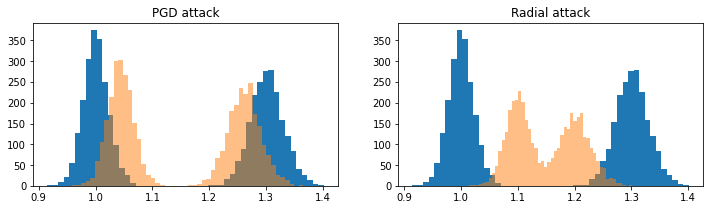

In [7]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50, label="x_test");
plt.hist(np.linalg.norm(res["x_test_adv_pgd"], ord=2, axis=-1), bins=50, label="x_test_adv", alpha=0.5);
plt.title(f"PGD attack");

plt.subplot(1, 2, 2)
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50, label="x_test");
plt.hist(np.linalg.norm(res["x_test_adv_rad"], ord=2, axis=-1), bins=50, label="x_test_adv", alpha=0.5);
plt.title(f"Radial attack");

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Wall time: 8.55 s


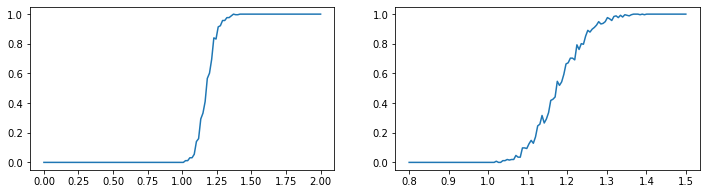

In [8]:
%%time
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
rads = np.linspace(start=0, stop=2, num=128)
cls1_fracs = cls1_frac_by_rad(model=res["model"], rads=rads)
plt.plot(rads, cls1_fracs);

plt.subplot(1, 2, 2)
rads = np.linspace(start=0.8, stop=1.5, num=128)
cls1_fracs = cls1_frac_by_rad(model=res["model"], rads=rads)
plt.plot(rads, cls1_fracs);

---

Norm $O(1)$, adversarial training

In [12]:
%%time
D = 1000
res = run_experiment_v2(
    dim=D, s0=1.0 / np.sqrt(D), s1=1.3 / np.sqrt(D),
    num_train=10 ** 4,
    model_layers=[
        layers.Dense(1000, activation="relu"),
        layers.Dense(1000, activation="relu"),
        layers.Dense(2),
    ],
    train_batch_size=256,
    train_epochs=50,
    attack_norm=2,
    attack_eps=0.1,
    attack_eps_step=0.01,
    attack_iters=20,
    adv_train=True,
    adv_train_log_interval=4,
    seed=43
)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Finished epoch 0; acc=0.4834; val_accs=(0.0000, 1.0000); loss=0.704688310623169
Finished epoch 4; acc=0.8605; val_accs=(0.3569, 0.0962); loss=0.43349847197532654
Finished epoch 8; acc=1.0000; val_accs=(0.3667, 0.0825); loss=0.002777048386633396
Finished epoch 12; acc=1.0000; val_accs=(0.4966, 0.0576); loss=0.0007692933431826532
Finished epoch 16; acc=1.0000; val_accs=(0.5635, 0.0469); loss=0.000243436501477845
Finished epoch 20; acc=1.0000; val_accs=(0.6660, 0.0278); loss=8.863885886967182e-05
Finished epoch 24; acc=1.0000; val_accs=(0.7334, 0.0171); loss=4.2101990402443334e-05
Finished epoch 28; acc=1.0000; val_accs=(0.7798, 0.0151); loss=2.484294782334473e-05
Finished epoch 32; acc=1.0000; val_accs=(0.8062, 0.0142); loss=1.6264661098830402e-05
Finished epoch 36; acc=1.0000; val_accs=(0.8027, 0.0146); loss=1.2006554243271239e-05
Finished epoch 40; acc=1.0000; val_accs=(0.7983, 0.0146); loss=9.399936971021816e-06
Finished epoch 44; acc=1.0000; val_accs=(0.7949, 0.0146); loss=7.34643799

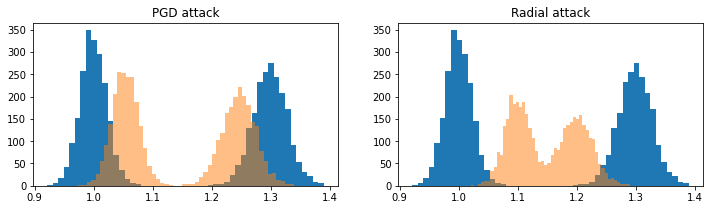

In [13]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50, label="x_test");
plt.hist(np.linalg.norm(res["x_test_adv_pgd"], ord=2, axis=-1), bins=50, label="x_test_adv", alpha=0.5);
plt.title(f"PGD attack");

plt.subplot(1, 2, 2)
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50, label="x_test");
plt.hist(np.linalg.norm(res["x_test_adv_rad"], ord=2, axis=-1), bins=50, label="x_test_adv", alpha=0.5);
plt.title(f"Radial attack");

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

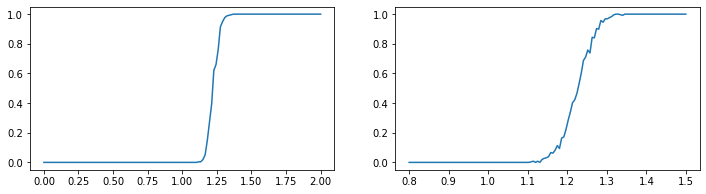

In [14]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
rads = np.linspace(start=0, stop=2, num=128)
cls1_fracs = cls1_frac_by_rad(model=res["model"], rads=rads)
plt.plot(rads, cls1_fracs);

plt.subplot(1, 2, 2)
rads = np.linspace(start=0.8, stop=1.5, num=128)
cls1_fracs = cls1_frac_by_rad(model=res["model"], rads=rads)
plt.plot(rads, cls1_fracs);

---

### Summary and conclusions

Major observations:
1. PGD attack much more severe than the non-classifier dependent radius attack.
   This suggests that the vulnerability of the NN is not that transferable,
   and has more to due with the "noise" that the NN learns.
2. Adversarial training does not give perfect robustness.
   When trained to convergence,
   the inner sphere is fairly robust but the outer sphere has 0 robustness.
3. Both natural training and adversarial training results in good natural accuracy.